In [35]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

plt.style.use('ggplot')
%matplotlib inline

Assignment: https://github.com/mrdtirado/graphs-communities

Lecture: https://github.com/gSchool/DSI_Lectures/blob/master/graphs/natalie_hunt/graphs_lecture.ipynb

# Graphs: Centrality & Communities

We'll still be dealing with the same IMDb dataset that we used in the morning. We're going to be finding the most important nodes in the graph and communities within the graph.

## Actor and movie edge files

Let's start by dealing with a file that only has actor edges. Two actors are connected if they've been in a movie together. An edge in the file will look like this:

```
 Kevin Bacon    Ryan Gosling
```

This means that Kevin Bacon and Ryan Gosling were in a movie together.

The analogous can be done for movies to create movie edges. Two movies are connected if an actor was in both of them.

We already have a script for you that will create these edge files for you. You can run the script with this command:

## Intro to networkx

In [3]:
G = nx.read_edgelist('/home/asus/G_school_lectures/Week_8_Lectures/graphs-communities/data/imdb_edges.tsv', delimiter='\t')

In [8]:
# how many nodes and edges are there in the graph?
print(G.number_of_edges())
print(G.number_of_nodes())

154795
97944


In [391]:
karateG = nx.karate_club_graph()

In [12]:
nx.shortest_path(G, source = 'Kevin Bacon', target = 'Julia Roberts')

['Kevin Bacon',
 'Beyond All Boundaries',
 'Tom Hanks',
 'Larry Crowne',
 'Julia Roberts']

## Measures of Centrality and Connected Components
There are a few different ways to measure the most important nodes.

1. We're going to work with the graph that only has actors. Run the `src/make_edge_files.py` script and then load in the `data/actor_edges.tsv` into a networkx graph.

In [377]:
actors_small = nx.read_edgelist('/home/asus/G_school_lectures/Week_8_Lectures/graphs-communities/data/small_actor_edges.tsv',delimiter='\t')
movies_small = nx.read_edgelist('/home/asus/G_school_lectures/Week_8_Lectures/graphs-communities/data/small_movie_edges.tsv', delimiter='\t')

In [56]:
actors.number_of_edges()

11782


2. Use networkx to get the *degree* of all the nodes and make a histogram to get an understanding of the distribution of degrees. To get a dictionary of all the nodes and their degrees, use `dict(G.degree())`

In [57]:
actor_his = dict(actors_small.degree())

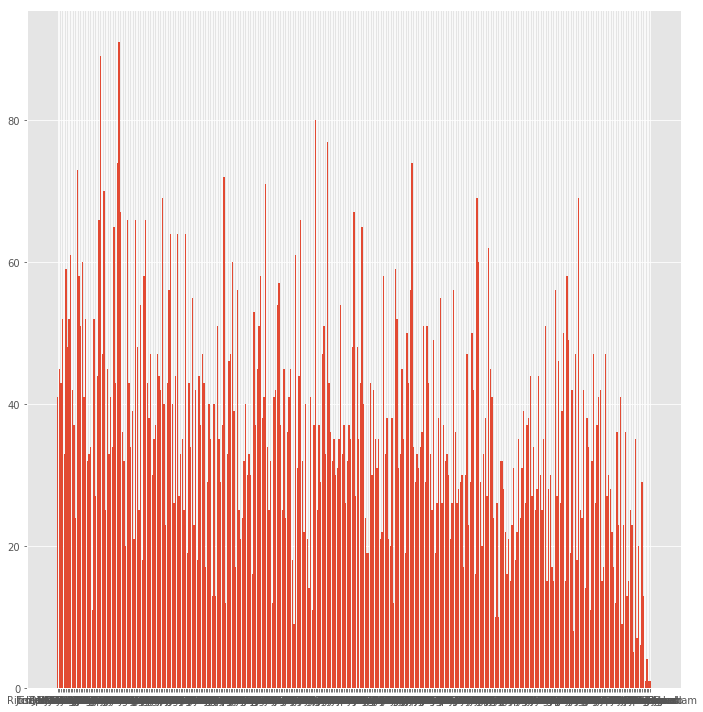

In [65]:
fig, ax = plt.subplots(1, figsize=(10,10))

ax.bar(actor_his.keys(), actor_his.values())
plt.tight_layout()


3. Who is the most important actor according to degree centrality?

    Note that this is a good place to use a `Counter` since it has a `most_common` method:

In [59]:
Counter(nx.degree_centrality(actors_small)).most_common(5)

[('David Koechner', 0.2556179775280899),
 ('Justin Long', 0.25),
 ('Danny Trejo', 0.2247191011235955),
 ('Paul Rudd', 0.21629213483146068),
 ('Will Ferrell', 0.20786516853932585)]

4. How many connected components are there?

In [60]:
len(nx.degree_centrality(actors_small))

357


5. Make a histogram of the sizes of the connected components.

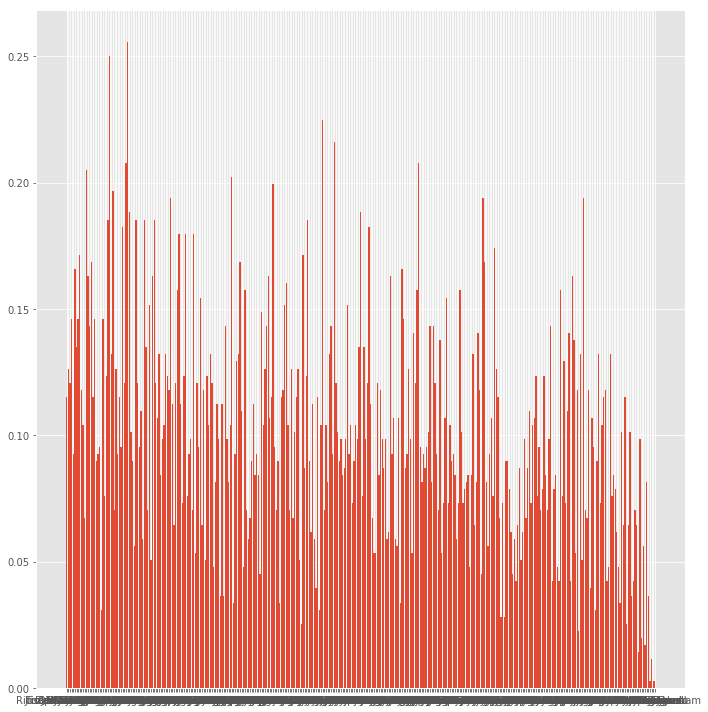

In [66]:
fig, ax = plt.subplots(1, figsize=(10,10))

ax.bar(nx.degree_centrality(actors_small).keys(), nx.degree_centrality(actors_small).values())
plt.tight_layout()

6. Who is the most important actor in this subgraph according to degree centrality?

In [62]:
Counter(nx.degree_centrality(actors_small)).most_common(5)

[('David Koechner', 0.2556179775280899),
 ('Justin Long', 0.25),
 ('Danny Trejo', 0.2247191011235955),
 ('Paul Rudd', 0.21629213483146068),
 ('Will Ferrell', 0.20786516853932585)]

7. Who is the most important actor according to betweenness centrality?


In [63]:
Counter(nx.betweenness_centrality(actors_small)).most_common(5)

[('Danny Trejo', 0.01740584221975875),
 ('Justin Long', 0.01243551489449646),
 ('David Koechner', 0.011794132340103444),
 ('John Goodman', 0.011654586260132866),
 ('Samuel L. Jackson', 0.010876961690659522)]

8. Who is the most important actor according to eigenvector centrality?


In [64]:
Counter(nx.eigenvector_centrality(actors_small)).most_common(5)

[('David Koechner', 0.1404633804614843),
 ('Justin Long', 0.1311531601375571),
 ('Paul Rudd', 0.1284060091198865),
 ('Will Ferrell', 0.12554471950955165),
 ('Seth Rogen', 0.11651627384579409)]

In [80]:
e_centralities = nx.edge_betweenness_centrality(actors_small)

In [84]:
e_centralities['Ritchie Montgomery']

KeyError: 'Ritchie Montgomery'

In [83]:
[key for key in e_centralities]

SyntaxError: invalid syntax (<ipython-input-83-e9a7401aca47>, line 1)

In [79]:
[key for key in nx.betweenness_centrality(actors_small)[key] == max(nx.betweenness_centrality(actors_small)).values]

NameError: name 'key' is not defined

In [361]:
def girvan_newman_step(G):
    """Run one step of the Girvan-Newman community detection algorithm.

    Afterwards, the graph will have one more connected component.

    Parameters
    ----------
    G: networkx Graph object

    Returns
    -------
    None
    """
#     G = G.copy()
    num_comps = len([com for com in nx.connected_components(G)])
    new_num_comps = num_comps
    e_centralities = nx.edge_betweenness_centrality(G)
    
    # repeat untill a new connected component is created
    # will stop every time a new communtiy is formed
    while new_num_comps == num_comps:
        # get the edge values
        # remove the top edges
        highest_edge = [key for key in e_centralities if e_centralities[key] ==max(e_centralities.values())]
#         print(highest_edge)
        for e in highest_edge:
            G.remove_edge(e[0], e[1])
#             print(e)
            e_centralities.pop(e)
        new_num_comps = len([com for com in nx.connected_components(G)])
        print('New', new_num_comps, 'old', num_comps)
#         print(len(G))
#         print(highest_edge)

In [362]:
girvan_newman_step(actors_small)

New 4 old 1


In [166]:
def find_communities_n(G, n):
    """Return communites of G after running Girvan-Newman algorithm n steps.

    Parameters
    ----------
    G: networkx Graph object
    n: int

    Returns
    -------
    list of lists
    """
    G1 = G.copy()
    for i in range(n):
        girvan_newman_step(G1)
    return list(nx.connected_components(G1))

In [171]:
find_communities_n(actors_small, n=5)

New 2 old 1
New 4 old 2
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 4 old 4
New 5 old 4
New 6 old 5
New 6 old 6
New 6 old 6
New 6 old 6
New 6 old 6
New 7 old 6


[{'50 Cent',
  'Aasif Mandvi',
  'Adam LeFevre',
  'Adam Scott',
  'Aidan Quinn',
  'Al Pacino',
  'Alan Arkin',
  'Alec Baldwin',
  'Alfred Molina',
  'Allison Janney',
  'Amanda Seyfried',
  'Amy Adams',
  'Amy Poehler',
  'Anna Kendrick',
  'Anthony Hopkins',
  'Anthony Mackie',
  'Arielle Kebbel',
  'Bai Ling',
  'Beau Bridges',
  'Ben Foster',
  'Ben Kingsley',
  'Ben Stiller',
  'Beth Grant',
  'Bill Hader',
  'Bill Moseley',
  'Bill Murray',
  'Billy Burke',
  'Billy Crudup',
  'Bob Gunton',
  'Bobby Cannavale',
  'Bonnie Johnson',
  'Brad Dourif',
  'Brad Pitt',
  'Bradley Cooper',
  'Brett Rice',
  'Brian Cox',
  'Bruce Davison',
  'Bruce McGill',
  'Bruce Willis',
  'Bryan Cranston',
  'C. Thomas Howell',
  'Cam Gigandet',
  'Carla Gugino',
  'Carlos Alazraqui',
  'Carmen Electra',
  'Cedric the Entertainer',
  'Channing Tatum',
  'Chazz Palminteri',
  'Chlo? Moretz',
  'Chris Evans',
  'Chris Messina',
  'Chris Mulkey',
  'Chris Parnell',
  'Chris Pratt',
  'Christa Campbell

In [182]:
def get_modularity(subgraphs, degrees, num_edges):
    """Return the value of the modularity for the graph G.

    Parameters
    ----------
    subgraphs: generator
        Graph broken in subgraphs
    degrees: dictionary
        Node: degree key-value pairs from original graph
    num_edges: float
        Number of edges in original graph

    Returns
    -------
    float
        Modularity value, between -0.5 and 1
    """
    
    matrix = nx.to_numpy_matrix(actors_small)
    

In [183]:
matrix = nx.to_numpy_matrix(actors_small)

In [321]:
matrix

matrix([[0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [191]:
degree_nodes = actors_small.degree() ; degree_nodes

DegreeView({'Ritchie Montgomery': 41, 'Tim Blake Nelson': 45, 'Jessica Alba': 43, 'Val Kilmer': 52, 'Queen Latifah': 33, 'Will Arnett': 59, 'Joseph Gordon-Levitt': 48, 'Nicolas Cage': 52, 'Zach Galifianakis': 61, 'Ed Harris': 42, 'Helen Mirren': 37, 'Jeremy Irons': 24, 'Stanley Tucci': 73, 'Bill Hader': 58, 'Kristen Bell': 51, 'Danny McBride': 60, 'George Clooney': 41, 'Channing Tatum': 52, 'Jamie Foxx': 32, 'Jessica Chastain': 33, 'Tom Wilkinson': 34, 'Jack Nicholson': 11, 'Kathryn Hahn': 52, 'Kevin Kline': 27, 'Tony Hale': 44, 'Jonah Hill': 66, 'Justin Long': 89, 'Josh Lucas': 47, 'Woody Harrelson': 70, 'Diora Baird': 25, 'Tom Arnold': 45, 'Alfred Molina': 33, 'Dermot Mulroney': 41, 'Lochlyn Munro': 34, 'Stephen Root': 65, 'Molly Shannon': 43, 'Will Ferrell': 74, 'David Koechner': 91, 'Owen Wilson': 67, 'Anna Kendrick': 36, 'Dennis Quaid': 32, 'Jason Mewes': 20, 'Seth Rogen': 66, 'Christa Campbell': 43, 'Jeff Chase': 34, 'Jessica Biel': 39, 'Jon Voight': 21, 'Vince Vaughn': 66, 'Fore

In [207]:
dict(degree_nodes)

{'Ritchie Montgomery': 41,
 'Tim Blake Nelson': 45,
 'Jessica Alba': 43,
 'Val Kilmer': 52,
 'Queen Latifah': 33,
 'Will Arnett': 59,
 'Joseph Gordon-Levitt': 48,
 'Nicolas Cage': 52,
 'Zach Galifianakis': 61,
 'Ed Harris': 42,
 'Helen Mirren': 37,
 'Jeremy Irons': 24,
 'Stanley Tucci': 73,
 'Bill Hader': 58,
 'Kristen Bell': 51,
 'Danny McBride': 60,
 'George Clooney': 41,
 'Channing Tatum': 52,
 'Jamie Foxx': 32,
 'Jessica Chastain': 33,
 'Tom Wilkinson': 34,
 'Jack Nicholson': 11,
 'Kathryn Hahn': 52,
 'Kevin Kline': 27,
 'Tony Hale': 44,
 'Jonah Hill': 66,
 'Justin Long': 89,
 'Josh Lucas': 47,
 'Woody Harrelson': 70,
 'Diora Baird': 25,
 'Tom Arnold': 45,
 'Alfred Molina': 33,
 'Dermot Mulroney': 41,
 'Lochlyn Munro': 34,
 'Stephen Root': 65,
 'Molly Shannon': 43,
 'Will Ferrell': 74,
 'David Koechner': 91,
 'Owen Wilson': 67,
 'Anna Kendrick': 36,
 'Dennis Quaid': 32,
 'Jason Mewes': 20,
 'Seth Rogen': 66,
 'Christa Campbell': 43,
 'Jeff Chase': 34,
 'Jessica Biel': 39,
 'Jon Voi

In [323]:
degree_values = np.array(degree_nodes)[:,1] ; degree_values

array(['41', '45', '43', '52', '33', '59', '48', '52', '61', '42', '37',
       '24', '73', '58', '51', '60', '41', '52', '32', '33', '34', '11',
       '52', '27', '44', '66', '89', '47', '70', '25', '45', '33', '41',
       '34', '65', '43', '74', '91', '67', '36', '32', '20', '66', '43',
       '34', '39', '21', '66', '48', '25', '54', '18', '58', '66', '43',
       '38', '47', '30', '35', '37', '47', '44', '42', '69', '40', '23',
       '43', '56', '64', '40', '26', '44', '64', '27', '33', '35', '25',
       '64', '19', '43', '34', '55', '23', '42', '18', '44', '37', '47',
       '43', '17', '29', '40', '35', '13', '40', '13', '51', '35', '29',
       '37', '72', '12', '33', '46', '47', '60', '39', '17', '56', '25',
       '21', '24', '32', '40', '30', '33', '30', '16', '53', '37', '45',
       '51', '58', '38', '41', '71', '34', '25', '32', '12', '41', '42',
       '54', '57', '37', '25', '45', '24', '36', '41', '45', '18', '9',
       '61', '31', '44', '66', '32', '22', '40', '21

In [256]:
degree_values.shape

(357,)

In [272]:
lst = []

for i in range(len(degree_values)):
    test = int(degree_values[i])
    
    lst.append(test)
    #     print(degree_values[i])

In [324]:
lst

[41,
 45,
 43,
 52,
 33,
 59,
 48,
 52,
 61,
 42,
 37,
 24,
 73,
 58,
 51,
 60,
 41,
 52,
 32,
 33,
 34,
 11,
 52,
 27,
 44,
 66,
 89,
 47,
 70,
 25,
 45,
 33,
 41,
 34,
 65,
 43,
 74,
 91,
 67,
 36,
 32,
 20,
 66,
 43,
 34,
 39,
 21,
 66,
 48,
 25,
 54,
 18,
 58,
 66,
 43,
 38,
 47,
 30,
 35,
 37,
 47,
 44,
 42,
 69,
 40,
 23,
 43,
 56,
 64,
 40,
 26,
 44,
 64,
 27,
 33,
 35,
 25,
 64,
 19,
 43,
 34,
 55,
 23,
 42,
 18,
 44,
 37,
 47,
 43,
 17,
 29,
 40,
 35,
 13,
 40,
 13,
 51,
 35,
 29,
 37,
 72,
 12,
 33,
 46,
 47,
 60,
 39,
 17,
 56,
 25,
 21,
 24,
 32,
 40,
 30,
 33,
 30,
 16,
 53,
 37,
 45,
 51,
 58,
 38,
 41,
 71,
 34,
 25,
 32,
 12,
 41,
 42,
 54,
 57,
 37,
 25,
 45,
 24,
 36,
 41,
 45,
 18,
 9,
 61,
 31,
 44,
 66,
 32,
 22,
 40,
 21,
 14,
 41,
 11,
 37,
 80,
 25,
 37,
 29,
 47,
 51,
 33,
 77,
 43,
 36,
 32,
 35,
 30,
 31,
 35,
 54,
 33,
 37,
 26,
 32,
 37,
 35,
 48,
 67,
 27,
 48,
 35,
 43,
 65,
 40,
 24,
 19,
 19,
 43,
 30,
 42,
 35,
 31,
 35,
 21,
 22,
 58,
 33,
 38,
 21,
 

In [274]:
test = np.array(lst) ; test

array([41, 45, 43, 52, 33, 59, 48, 52, 61, 42, 37, 24, 73, 58, 51, 60, 41,
       52, 32, 33, 34, 11, 52, 27, 44, 66, 89, 47, 70, 25, 45, 33, 41, 34,
       65, 43, 74, 91, 67, 36, 32, 20, 66, 43, 34, 39, 21, 66, 48, 25, 54,
       18, 58, 66, 43, 38, 47, 30, 35, 37, 47, 44, 42, 69, 40, 23, 43, 56,
       64, 40, 26, 44, 64, 27, 33, 35, 25, 64, 19, 43, 34, 55, 23, 42, 18,
       44, 37, 47, 43, 17, 29, 40, 35, 13, 40, 13, 51, 35, 29, 37, 72, 12,
       33, 46, 47, 60, 39, 17, 56, 25, 21, 24, 32, 40, 30, 33, 30, 16, 53,
       37, 45, 51, 58, 38, 41, 71, 34, 25, 32, 12, 41, 42, 54, 57, 37, 25,
       45, 24, 36, 41, 45, 18,  9, 61, 31, 44, 66, 32, 22, 40, 21, 14, 41,
       11, 37, 80, 25, 37, 29, 47, 51, 33, 77, 43, 36, 32, 35, 30, 31, 35,
       54, 33, 37, 26, 32, 37, 35, 48, 67, 27, 48, 35, 43, 65, 40, 24, 19,
       19, 43, 30, 42, 35, 31, 35, 21, 22, 58, 33, 38, 21, 20, 38, 12, 59,
       52, 31, 33, 45, 35, 19, 50, 43, 56, 74, 34, 29, 33, 31, 34, 36, 51,
       29, 51, 43, 33, 25

In [325]:
test.astype(int)

array([41, 45, 43, 52, 33, 59, 48, 52, 61, 42, 37, 24, 73, 58, 51, 60, 41,
       52, 32, 33, 34, 11, 52, 27, 44, 66, 89, 47, 70, 25, 45, 33, 41, 34,
       65, 43, 74, 91, 67, 36, 32, 20, 66, 43, 34, 39, 21, 66, 48, 25, 54,
       18, 58, 66, 43, 38, 47, 30, 35, 37, 47, 44, 42, 69, 40, 23, 43, 56,
       64, 40, 26, 44, 64, 27, 33, 35, 25, 64, 19, 43, 34, 55, 23, 42, 18,
       44, 37, 47, 43, 17, 29, 40, 35, 13, 40, 13, 51, 35, 29, 37, 72, 12,
       33, 46, 47, 60, 39, 17, 56, 25, 21, 24, 32, 40, 30, 33, 30, 16, 53,
       37, 45, 51, 58, 38, 41, 71, 34, 25, 32, 12, 41, 42, 54, 57, 37, 25,
       45, 24, 36, 41, 45, 18,  9, 61, 31, 44, 66, 32, 22, 40, 21, 14, 41,
       11, 37, 80, 25, 37, 29, 47, 51, 33, 77, 43, 36, 32, 35, 30, 31, 35,
       54, 33, 37, 26, 32, 37, 35, 48, 67, 27, 48, 35, 43, 65, 40, 24, 19,
       19, 43, 30, 42, 35, 31, 35, 21, 22, 58, 33, 38, 21, 20, 38, 12, 59,
       52, 31, 33, 45, 35, 19, 50, 43, 56, 74, 34, 29, 33, 31, 34, 36, 51,
       29, 51, 43, 33, 25

In [287]:
matrix

matrix([[0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [282]:
num_edges = len(actors_small.edges)
num_edges

6433

In [328]:
np.sum([8,9,10])

27

In [297]:
test.T.reshape(,357)

SyntaxError: invalid syntax (<ipython-input-297-1149bf7b463e>, line 1)

In [405]:
def girvan_newman_step(G, pprint=False, pop1=True):
    """Run one step of the Girvan-Newman community detection algorithm.

    Afterwards, the graph will have one more connected component.

    Parameters
    ----------
    G: networkx Graph object

    Returns
    -------
    None
    """
    #MUST MODIFY THE ORIGINAL 
    satisfied = 'no'
    #modify G
    num_comps = len([com for com in nx.connected_components(G)])
    new_num_comps = num_comps
    
    
    #GET THE EDGE-CENTRALITIES
    e_centralities = nx.edge_betweenness_centrality(G, normalized=True, weight=None)
          
        #repeat until a new connected component is created:
    while new_num_comps == num_comps:

        if pop1:
            #REMOVE THE TOP EDGE(S) 
            e = [key for key in e_centralities if e_centralities[key] == max(e_centralities.values())][0]
            if pprint: print('Removing ', e)
            e_centralities.pop(e)
            #UPDATE G ->>>>>> G.remove_node()
            G.remove_edge(e[0],e[1])
        else:
            #REMOVE THE TOP EDGE(S) 
            highest_edges = [key for key in e_centralities if e_centralities[key] == max(e_centralities.values())]
            for e in highest_edges: 
                if pprint: print('Removing ', e)
                e_centralities.pop(e)
                #UPDATE G ->>>>>> G.remove_node()
                G.remove_edge(e[0],e[1])

                
        #GET NUMBER OF NEW COMPONENTS
        new_num_comps = len([com for com in nx.connected_components(G)])
        if pprint: print('OLD/NEW Components: ', num_comps, new_num_comps)

In [406]:
import networkx as nx
from collections import Counter

def find_communities_n(G, n):
    """Return communites of G after running Girvan-Newman algorithm n steps.

    Parameters
    ----------
    G: networkx Graph object
    n: int

    Returns
    -------
    list of lists
    """
    G1 = G.copy()
    for i in range(n):
        girvan_newman_step(G1)
    return list(nx.connected_components(G1))

In [410]:
def get_modularity(subgraphs, degrees, num_edges):
    """Return the value of the modularity for the graph G.

    Parameters
    ----------
    subgraphs: generator
        Graph broken in subgraphs
    degrees: dictionary
        Node: degree key-value pairs from original graph
    num_edges: float
        Number of edges in original graph

    Returns
    -------
    float
        Modularity value, between -0.5 and 1
    """
    sums = []
    
    sgs = [sg for sg in subgraphs]
    
    # loop through all the subgraphs created by subgraphs generator
    for s in sgs:
        # PULL OUT THE DEGREES FOR EACH COMMUNITY
        degrees = dict(s.degree())
        # converty degrees to matrix
        D = np.matrix(list(degrees.values()))
        #create di*dj matrix
        DD = (D.T*D)/num_edges/2
        # create Adjacency Matrix
        A = nx.to_numpy_matrix(s)
        # generate sum for subgroup AKA community
        sums.append(np.sum(A-DD)/2/num_edges)
    return sum(sums)

def get_modularity(subgraphs, degrees, num_edges):
    """Return the value of the modularity for the graph G.

    Parameters
    ----------
    subgraphs: generator
        Graph broken in subgraphs
    degrees: dictionary
        Node: degree key-value pairs from original graph
    num_edges: float
        Number of edges in original graph

    Returns
    -------
    float
        Modularity value, between -0.5 and 1
    """
    subgraph = [thing for thing in subgraphs]
    lst_of_modularity_values = []
    # loop through all the subgraphs created by subgraphs generator
    for i in subgraph:
        # get the degree for all nodes within the subgraph
        degrees = dict(i.degree())
        # convert degrees to a matrix
        D = np.matrix(list(degrees.values()))
        # turn dictionary into an array
        degree_values = np.array(degree_nodes)[:,1]
        # fix bug to make sure they're ints
        degree_values = degree_values.astype(int)
        vert = degree_values.reshape(-1, 1)
        hor = degree_values.reshape(1, -1)
        modularity_value = np.sum(matrix - ((test * test.T)/(2*num_edges)))
        lst_of_modularity_values.append(modularity_value)
    return np.sum(lst_of_modularity_values)/ (2*num_edges)

In [413]:
def find_communities_modularity(G, max_iter=None):
    """Return communities with the maximum modularity from G.

    Run Girvan-Newman algorithm on G and find communities with max modularity.

    Parameters
    ----------
    G: networkx Graph object
    max_iter: int, (optional, default=None)
        Maximum number of iterations

    Returns
    -------
    list of lists of strings
        Strings are node names
    """
    degrees = G.degree()
    num_edges = G.number_of_edges()
    G1 = G.copy()
    best_modularity = -1.0
    best_comps = nx.connected_components(G1)
    i = 0
    while G1.number_of_edges() > 0:
        subgraphs = nx.connected_component_subgraphs(G1)
        modularity = get_modularity(subgraphs, degrees, num_edges)
        if modularity > best_modularity:
            best_modularity = modularity
            best_comps = list(nx.connected_components(G1))
        girvan_newman_step(G1)
        i += 1
#         print(i, modularity)
        if max_iter and i >= max_iter:
            break
    return best_comps

In [414]:
find_communities_modularity(karateG)

1 -2.419716848542008e-17
2 0.10207100591715976
3 0.26166995397764625
4 0.4993425378040763
5 0.47074293228139386
6 0.4636752136752137
7 0.4842209072978304
8 0.4764957264957265
9 0.40269559500328733
10 0.3829717291255753
11 0.3648915187376726
12 0.356508875739645
13 0.3451676528599606
14 0.32741617357001973
15 0.3154174884944116
16 0.30341880341880345
17 0.2820512820512821
18 0.26298487836949375
19 0.2513149243918475
20 0.23093359631821173
21 0.2186061801446417
22 0.20627876397107167
23 0.1845825115055884
24 0.1615713346482577
25 0.14891518737672582
26 0.13625904010519396
27 0.12360289283366208
28 0.0992767915844839
29 0.08662064431295201
30 0.07396449704142012
31 0.04963839579224195
32 0.03698224852071006
33 0.012656147271531887


[{0, 1, 2, 3, 7, 9, 12, 13, 17, 19, 21},
 {4, 5, 6, 10, 16},
 {8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33},
 {11}]

In [309]:
hor = test.reshape(1,-1); hor

array([[41, 45, 43, 52, 33, 59, 48, 52, 61, 42, 37, 24, 73, 58, 51, 60,
        41, 52, 32, 33, 34, 11, 52, 27, 44, 66, 89, 47, 70, 25, 45, 33,
        41, 34, 65, 43, 74, 91, 67, 36, 32, 20, 66, 43, 34, 39, 21, 66,
        48, 25, 54, 18, 58, 66, 43, 38, 47, 30, 35, 37, 47, 44, 42, 69,
        40, 23, 43, 56, 64, 40, 26, 44, 64, 27, 33, 35, 25, 64, 19, 43,
        34, 55, 23, 42, 18, 44, 37, 47, 43, 17, 29, 40, 35, 13, 40, 13,
        51, 35, 29, 37, 72, 12, 33, 46, 47, 60, 39, 17, 56, 25, 21, 24,
        32, 40, 30, 33, 30, 16, 53, 37, 45, 51, 58, 38, 41, 71, 34, 25,
        32, 12, 41, 42, 54, 57, 37, 25, 45, 24, 36, 41, 45, 18,  9, 61,
        31, 44, 66, 32, 22, 40, 21, 14, 41, 11, 37, 80, 25, 37, 29, 47,
        51, 33, 77, 43, 36, 32, 35, 30, 31, 35, 54, 33, 37, 26, 32, 37,
        35, 48, 67, 27, 48, 35, 43, 65, 40, 24, 19, 19, 43, 30, 42, 35,
        31, 35, 21, 22, 58, 33, 38, 21, 20, 38, 12, 59, 52, 31, 33, 45,
        35, 19, 50, 43, 56, 74, 34, 29, 33, 31, 34, 36, 51, 29, 

In [313]:
arr_test = (vert * hor)

In [315]:
matrix - (arr_test/ 2*num_edges)

matrix([[-5.4069365e+06, -5.9344415e+06, -5.6706895e+06, ...,
         -5.2750600e+05, -1.3187650e+05, -1.3187650e+05],
        [-5.9344415e+06, -6.5134125e+06, -6.2239275e+06, ...,
         -5.7897000e+05, -1.4474250e+05, -1.4474250e+05],
        [-5.6706895e+06, -6.2239275e+06, -5.9473085e+06, ...,
         -5.5323800e+05, -1.3830950e+05, -1.3830950e+05],
        ...,
        [-5.2750600e+05, -5.7897000e+05, -5.5323800e+05, ...,
         -5.1464000e+04, -1.2866000e+04, -1.2866000e+04],
        [-1.3187650e+05, -1.4474250e+05, -1.3830950e+05, ...,
         -1.2866000e+04, -3.2165000e+03, -3.2165000e+03],
        [-1.3187650e+05, -1.4474250e+05, -1.3830950e+05, ...,
         -1.2866000e+04, -3.2165000e+03, -3.2165000e+03]])

In [320]:
# for a community 
(np.sum(matrix - ((test * test.T)/ (2*num_edges))))/(2*num_edges)


-0.19172132876471581

In [250]:
degree_nodes.values()

AttributeError: 'DegreeView' object has no attribute 'values'

In [265]:
test = np.array(lst)

In [267]:
test.shape

(356,)

In [174]:
def find_communities_modularity(G, max_iter=None):
    """Return communities with the maximum modularity from G.

    Run Girvan-Newman algorithm on G and find communities with max modularity.

    Parameters
    ----------
    G: networkx Graph object
    max_iter: int, (optional, default=None)
        Maximum number of iterations

    Returns
    -------
    list of lists of strings
        Strings are node names
    """
    degrees = G.degree()
    num_edges = G.number_of_edges()
    G1 = G.copy()
    best_modularity = -1.0
    best_comps = nx.connected_components(G1)
    i = 0
    while G1.number_of_edges() > 0:
        subgraphs = nx.connected_component_subgraphs(G1)
        modularity = get_modularity(subgraphs, degrees, num_edges)
        if modularity > best_modularity:
            best_modularity = modularity
            best_comps = list(nx.connected_components(G1))
        girvan_newman_step(G1)
        i += 1
        if max_iter and i >= max_iter:
            break
    return best_comps


In [175]:
find_communities_modularity(actors_small)

NameError: name 'get_modularity' is not defined